# SMCNOD - Member Probability

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat

## Data
with quality cuts

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5

absdev_1700d_0,absdev_580v_0,alpha1,alpha16,alpha50,alpha84,alpha99,alpha_kurt,alpha_mean,alpha_skew,alpha_std,chisq_1700d_0,chisq_580v_0,chisq_cont_1700d_0,chisq_cont_580v_0,comment,dec,feh1,feh16,feh50,feh84,feh99,feh_kurt,feh_mean,feh_skew,feh_std,field,fig_name,fileinfo,logg1,logg16,logg50,logg84,logg99,logg_kurt,logg_mean,logg_skew,logg_std,name,nspec_1700d,nspec_580v,prior_type,proc_file_list,ra,redchisq_1700d_0,redchisq_580v_0,sn_1700d_0,sn_580v_0,teff1,teff16,teff50,teff84,teff99,teff_kurt,teff_mean,teff_skew,teff_std,utmjd,utmjd_mean,vel1,vel16,vel50,vel84,vel99,vel_blue1,vel_blue16,vel_blue50,vel_blue84,vel_blue99,vel_blue_kurt,vel_blue_mean,vel_blue_skew,vel_blue_std,vel_kurt,vel_mean,vel_skew,vel_std,fname,absdev_580v_1,chisq_580v_1,chisq_cont_580v_1,redchisq_580v_1,sn_580v_1,absdev_1700d_1,chisq_1700d_1,chisq_cont_1700d_1,redchisq_1700d_1,sn_1700d_1,absdev_1700d_2,chisq_1700d_2,chisq_cont_1700d_2,redchisq_1700d_2,sn_1700d_2,absdev_580v_2,chisq_580v_2,chisq_cont_580v_2,redchisq_580v_2,sn_580v_2,absdev_1700d_3,absdev_1700d_4,absdev_1700d_5,absdev_580v_3,absdev_580v_4,absdev_580v_5,chisq_1700d_3,chisq_1700d_4,chisq_1700d_5,chisq_580v_3,chisq_580v_4,chisq_580v_5,chisq_cont_1700d_3,chisq_cont_1700d_4,chisq_cont_1700d_5,chisq_cont_580v_3,chisq_cont_580v_4,chisq_cont_580v_5,redchisq_1700d_3,redchisq_1700d_4,redchisq_1700d_5,redchisq_580v_3,redchisq_580v_4,redchisq_580v_5,sn_1700d_3,sn_1700d_4,sn_1700d_5,sn_580v_3,sn_580v_4,sn_580v_5,ebv,gaia_source_id,dr2_source_id,phot_bp_rp_excess_factor,parallax,parallax_error,phot_g_mean_mag,source_id,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_bp_mean_mag,phot_rp_mean_mag,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bjdist_flag,w1mpro,w2mpro,w1sigmpro,w2sigmpro,j_2mass,h_2mass,k_2mass,u_skm,e_u_skm,v_skm,e_v_skm,g_skm,e_g_skm,r_skm,e_r_skm,i_skm,e_i_skm,z_skm,e_z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,qso_flag_wise,priority,object_name,sesar_s3ab,sesar_s3c,gaia_rr,p_bhb_decals,best_chisq_580v,best_absdev_580v,best_sn_580v,best_chisq_1700d,best_absdev_1700d,best_sn_1700d,good_star_pb,good_star,vel_calib,vel_calib_std,feh_calib_std,mass1,mass16,mass50,mass84,mass99,mass_mean,mass_std,mass_kurt,mass_skew,logage1,logage16,logage50,logage84,logage99,logage_mean,logage_std,logage_kurt,logage_skew,sp_feh1,sp_feh16,sp_feh50,sp_feh84,sp_feh99,sp_feh_mean,sp_feh_std,sp_feh_kurt,sp_feh_skew,sp_alpha1,sp_alpha16,sp_alpha50,sp_alpha84,sp_alpha99,sp_alpha_mean,sp_alpha_std,sp_alpha_kurt,sp_alpha_skew,logdist1,logdist16,logdist50,logdist84,logdist99,logdist_mean,logdist_std,logdist_kurt,logdist_skew,lmag_sys1,lmag_sys16,lmag_sys50,lmag_sys84,lmag_sys99,lmag_sys_mean,lmag_sys_std,lmag_sys_kurt,lmag_sys_skew,npost,sp_feh_calib_std,GDR3_solution_id,GDR3_source_id,GDR3_classprob_dsc_combmod_quasar,GDR3_classprob_dsc_combmod_galaxy,GDR3_classprob_dsc_combmod_star,GDR3_classprob_dsc_combmod_whitedwarf,GDR3_classprob_dsc_combmod_binarystar,GDR3_classprob_dsc_specmod_quasar,GDR3_classprob_dsc_specmod_galaxy,GDR3_classprob_dsc_specmod_star,GDR3_classprob_dsc_specmod_whitedwarf,GDR3_classprob_dsc_specmod_binarystar,GDR3_classprob_dsc_allosmod_quasar,GDR3_classprob_dsc_allosmod_galaxy,GDR3_classprob_dsc_allosmod_star,GDR3_teff_gspphot,GDR3_teff_gspphot_lower,GDR3_teff_gspphot_upper,GDR3_logg_gspphot,GDR3_logg_gspphot_lower,GDR3_logg_gspphot_upper,GDR3_mh_gspphot,GDR3_mh_gspphot_lower,GDR3_mh_gspphot_upper,GDR3_distance_gspphot,GDR3_distance_gspphot_lower,GDR3_distance_gspphot_upper,GDR3_azero_gspphot,GDR3_azero_gspphot_lower,GDR3_azero_gspphot_upper,GDR3_ag_gspphot,GDR3_ag_gspphot_lower,GDR3_ag_gspphot_upper,GDR3_abp_gspphot,GDR3_abp_gspphot_lower,GDR3_abp_gspphot_upper,GDR3_arp_gspphot,GDR3_arp_gspphot_lower,GDR3_arp_gspphot_upper,GDR3_ebpminrp_gspphot,GDR3_ebpminrp_gspphot_lower,GDR3_ebpminrp_gspphot_upper,GDR3_mg_gspphot,GDR3_mg_gspphot_lower,GDR3_mg_gspphot_upper,GDR3

In [3]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut
# subjective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab_1 = smcnod

In [4]:
len(tab)

291

In [5]:
len(tab_1)

150

## Posterior Parameters
mcmc result from full model

In [6]:
pgal =  0.590
pbg1 =  0.252
vhel =  101.836
lsigv =  1.319
feh =  -1.874
lsigfeh =  -0.515
vbg1 =  207.223
lsigvbg1 =  1.927
fehbg1 =  -1.564
lsigfeh1 =  -0.259
vbg2 =  43.238
lsigvbg2 =  1.774
fehbg2 =  -0.874
lsigfeh2 =  -0.385
pmra =  0.703
pmdec =  -1.128

theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra, pmdec

## Define Variables
The code define variables that are necessary for the next steps of the analysis, such as **radial velocity, metallicity, and proper motions**, and the respective errors, as well as creating arrays to store the proper motion data, and the covariance matrix. 

The code also assumes a uniform background and creates a dictionary containing some of these variables.

In [7]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [8]:
def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in fe
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = np.exp(lgal)
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = np.exp(lbgtot)
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

Now, check how many members we have are of "high" memberhsip probability.

To think about: what should the threshold for high memprob be set to?

In [9]:
sum(memprob(theta_opt) > 0.9)

171

In [10]:
sum(memprob(theta_opt) > 0.5)

173

In [11]:
# set the threshold to 0.5
tab['memberprob'] = memprob(theta_opt)
tab['membership'] = memprob(theta_opt) > 0.5
tab_good = tab[tab['memberprob'] > 0.5]
tab_bad = tab[tab['memberprob'] <= 0.5]

### Store the member data

In [12]:
# Save the member stars as a CSV file
# Convert to a pandas dataframe
df = tab_good.to_pandas()
df.to_csv('member_stars.csv', index=False)
df_1 = tab_bad.to_pandas()
df_1.to_csv('non_member_stars.csv', index=False)

## Visualizations

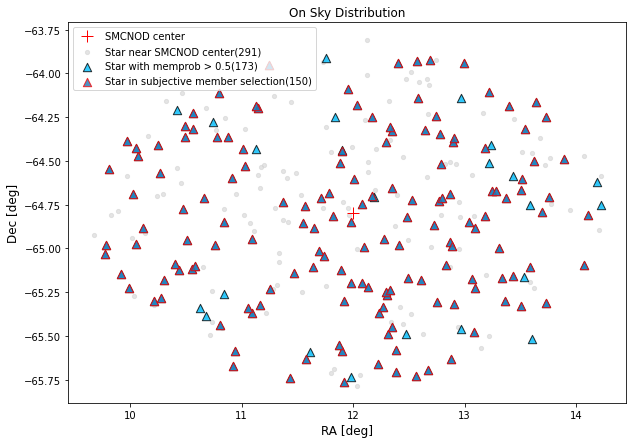

In [12]:
fig, ax = plt.subplots(figsize=(10,7))


plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='Star with memprob > 0.5(173)')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, ec='r', zorder=3, alpha=0.8,
        label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

In [13]:
# cut
g_band = tab['decam_g'] - 3.185 * tab['ebv']
r_band = tab['decam_r'] - 2.140 * tab['ebv']
i_band = tab['decam_i'] - 1.569 * tab['ebv']
g_cut = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_cut = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_cut = tab_good['decam_i'] - 1.569 * tab_good['ebv']
table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

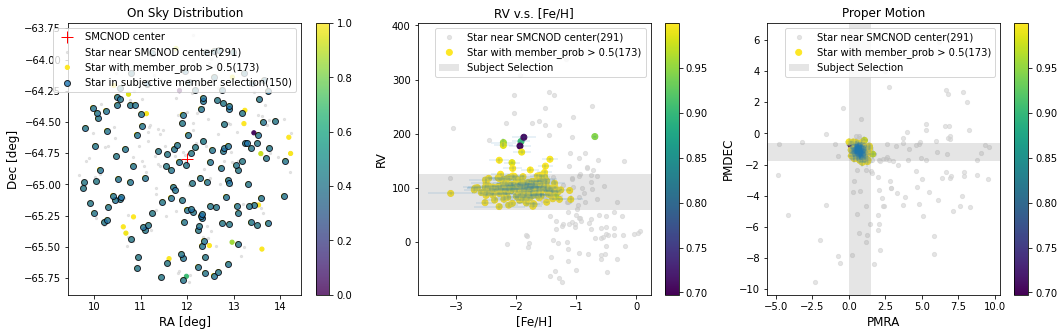

In [14]:
plt.figure(figsize=(24,5))
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='o',ec='k', zorder=5, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.colorbar()
plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.axhspan(60,125.5, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
plt.legend()
plt.colorbar()
plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.axvspan(0, 1.5, facecolor='grey', alpha=0.2)
plt.axhspan(-1.75, -0.6, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
#plt.xlim(-0.5,2)
#plt.ylim(-3,0.5)
plt.legend()
plt.colorbar()
plt.show()

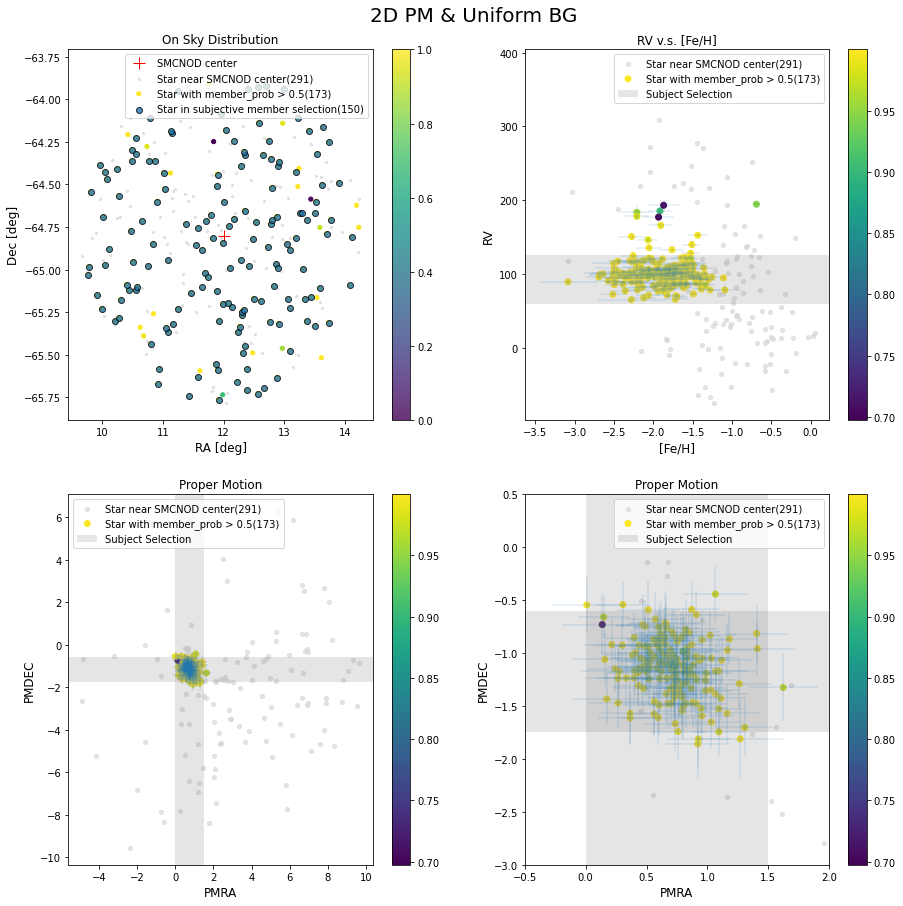

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='o',ec='k', zorder=5, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.colorbar()
plt.subplot(2,2,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.axhspan(60,125.5, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
plt.legend()
plt.colorbar()
plt.subplot(2,2,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.axvspan(0, 1.5, facecolor='grey', alpha=0.2)
plt.axhspan(-1.75, -0.6, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
#plt.xlim(-0.5,2)
#plt.ylim(-3,0.5)
plt.legend()
plt.colorbar()
plt.subplot(2,2,4)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.axvspan(0, 1.5, facecolor='grey', alpha=0.2)
plt.axhspan(-1.75, -0.6, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-3,0.5)
plt.legend()
plt.colorbar()
plt.suptitle("2D PM & Uniform BG", fontsize=20,y=0.92)
plt.show()

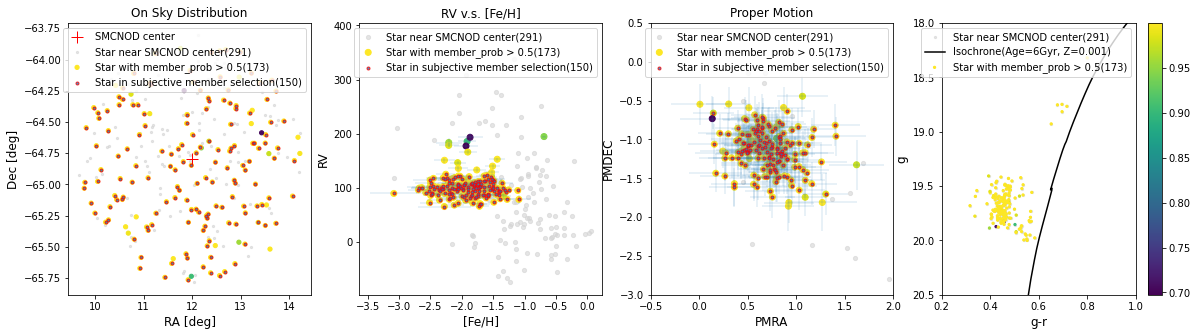

In [41]:
plt.figure(figsize=(20,5))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['feh50'],smcnod['vel_calib'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
plt.legend()

plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['pmra'],smcnod['pmdec'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-3,0.5)
plt.legend()


plt.legend()
plt.subplot(1,4,4)
plt.scatter(g_band - r_band, g_band,marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(Age=6Gyr, Z=0.001)')
plt.scatter(g_cut - r_cut, g_cut, marker='.', s=20, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(173)')
plt.xlim(0.2,1.0)
plt.ylim(18,20.5)
plt.xlabel('g-r', size = 12)
plt.ylabel('g', size = 12)
plt.gca().invert_yaxis()
plt.legend()
plt.colorbar()
plt.savefig('memberselect.png')
plt.show()

In [44]:
g_band = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_band = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_band = tab_good['decam_i'] - 1.569 * tab_good['ebv']
g_r = g_band - r_band
tab_good1 = tab_good[(g_band > 17) & (g_band < 23) & (g_r > 0.5) & (g_r < 1.2)]
tab_good1 = tab_good
# get the desired data
logg = tab_good1['logg50']
Teff = tab_good1['teff50']
FeH = tab_good1['feh50']

/var/folders/9w/8jsv_f1j1t357nbjlwl197kr0000gn/T/ipykernel_35925/2635805365.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,


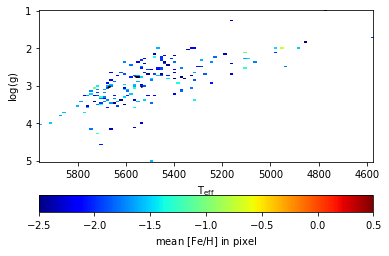

In [45]:
from astroML.stats import binned_statistic_2d
N, xedges, yedges = binned_statistic_2d(Teff, logg, FeH,
                                        'count', bins=100)
FeH_mean, xedges, yedges = binned_statistic_2d(Teff, logg, FeH,
                                               'mean', bins=100)

# Define custom colormaps: Set pixels with no sources to white
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

cmap_multicolor = plt.cm.jet
cmap_multicolor.set_bad('w', 1.)

plt.imshow(FeH_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[-1], yedges[0])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log(g)}$')

cb = plt.colorbar(ticks=np.arange(-2.5, 1, 0.5),
                  format=r'$%.1f$', orientation='horizontal')
cb.set_label(r'$\mathrm{mean\ [Fe/H]\ in\ pixel}$')
plt.clim(-2.5, 0.5)

# Draw density contours over the colors
levels = np.linspace(0, np.log10(N.max()), 7)[2:]
plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.show()